<a href="https://colab.research.google.com/github/mayank265/colab_learning/blob/main/T6_tutorial_time_series_forecasting_with_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Time Series Forecasting using XGBoost


In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

# PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [6]:
pjme = pd.read_csv('/content/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [8]:
pjme.isnull().sum()

PJME_MW    0
dtype: int64

In [9]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [10]:
pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


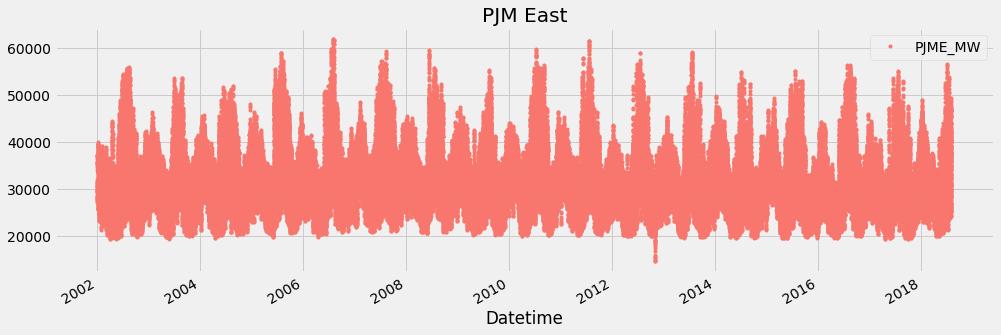

In [7]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [ ]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [ ]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create Time Series Features

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Create XGBoost Model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

In [ ]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [ ]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

# Look at Worst and Best Predicted Days

In [ ]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

# Plotting some best/worst predicted days

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')